# Transfer learning with the Neural Force Field

This Jupyter Notebook contains a demonstration on how to use the `nff` package to transfer learning between different methods. Most of it is similar to the first tutorial, and we'll go through the same steps when setting it up. The difference, however, is that we'll now train one model and later retrain its last layers to learn the new energies/forces.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts
from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
from nff.train.transfer import freeze_parameters, unfreeze_readout

In [2]:
DEVICE = 1
INDIR = './sandbox'
OUTDIR = './sandbox/transfer'
OUTDIR_2 = './sandbox/transfer2'
BATCH_SIZE = 100

if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
    os.mkdir(OUTDIR)
    
if os.path.exists(OUTDIR_2):
    shutil.rmtree(OUTDIR_2)
    os.mkdir(OUTDIR_2)

## Loading the relevant data

The dataset we'll work with contains ~500 geometries of ethanol, each calculated with the DLPNO-CCSD(T) level of theory. The procedure to create the validation sets will be exactly the same.

In [3]:
dataset = Dataset.from_file('./data/dataset_dlpno.pth.tar')

In [4]:
dset_train = dataset.copy()
dset_train.props['energy'] = dset_train.props.pop('energy_gga')
dset_train.props['energy_grad'] = dset_train.props.pop('energy_gga_grad')

dset_transf = dataset.copy()
dset_transf.props['energy'] = dset_transf.props.pop('energy_dlpno')
dset_transf.props['energy_grad'] = dset_transf.props.pop('energy_dlpno_grad')

In [5]:
split_datasets = {
    'normal': split_train_validation_test(dset_train, val_size=0.2, test_size=0.2),
    'transf': split_train_validation_test(dset_transf, val_size=0.2, test_size=0.7)
}

split_loaders = {
    key: {
        'train': DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts),
        'val': DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts),
        'test': DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
    }
    for key, (train, val, test) in split_datasets.items()
}

## Loading the pretrained model and freezing its convolution layers

In [6]:
params = {
    'n_atom_basis': 256,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True
}

model = get_model(params)

The model will be trained on GGA energies and forces. To do so, we just have to create a loss function for these parameters:

In [7]:
loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.01, 'energy_grad': 1})

We should also select an optimizer for our recently created model:

In [8]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

### Metrics and hooks

In [9]:
train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]

In [10]:
train_hooks = [
    hooks.MaxEpochHook(200),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S',
        log_memory=False
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

### Trainer wrapper

In [11]:
T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=split_loaders['normal']['train'],
    validation_loader=split_loaders['normal']['val'],
    checkpoint_interval=1,
    hooks=train_hooks
)

Now we can finally train the model using the method `train` from the `Trainer`:

In [12]:
T.train(device=DEVICE, n_epochs=50)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | 


 96%|█████████▌| 23/24 [00:01<00:00, 14.78it/s]


34:30 |     1 |     3.000e-04 |   293.4005 |        113.0101 |     8.1007 |          7.9608 | 


 96%|█████████▌| 23/24 [00:01<00:00, 15.41it/s]


34:32 |     2 |     3.000e-04 |    66.7141 |         45.2050 |     0.8370 |          4.9711 | 


 96%|█████████▌| 23/24 [00:01<00:00, 17.53it/s]


34:33 |     3 |     3.000e-04 |    33.0509 |         21.4585 |     0.6400 |          3.3756 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.39it/s]


34:35 |     4 |     3.000e-04 |    14.7631 |         11.1343 |     0.6545 |          2.4313 | 


 96%|█████████▌| 23/24 [00:01<00:00, 17.85it/s]


34:37 |     5 |     3.000e-04 |     8.0459 |          6.2205 |     0.6788 |          1.7661 | 


 96%|█████████▌| 23/24 [00:01<00:00, 17.65it/s]


34:38 |     6 |     3.000e-04 |     5.2825 |          5.2851 |     0.9325 |          1.6400 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.61it/s]


34:40 |     7 |     3.000e-04 |     4.3062 |          4.1341 |     0.6805 |          1.4361 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.40it/s]


34:42 |     8 |     3.000e-04 |     3.7786 |          3.4475 |     0.2036 |          1.3037 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.02it/s]


34:43 |     9 |     3.000e-04 |     3.3585 |          3.2192 |     0.1851 |          1.2611 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.08it/s]


34:45 |    10 |     3.000e-04 |     2.9627 |          2.9953 |     0.2259 |          1.2040 | 


 96%|█████████▌| 23/24 [00:01<00:00, 17.12it/s]


34:47 |    11 |     3.000e-04 |     2.6219 |          2.4036 |     0.2496 |          1.0701 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.59it/s]


34:49 |    12 |     3.000e-04 |     2.4745 |          2.1234 |     0.2516 |          0.9903 | 


 96%|█████████▌| 23/24 [00:01<00:00, 17.73it/s]


34:50 |    13 |     3.000e-04 |     2.0761 |          1.9681 |     0.2153 |          0.9556 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.11it/s]


34:52 |    14 |     3.000e-04 |     2.1094 |          1.9875 |     0.2009 |          0.9708 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.09it/s]


34:54 |    15 |     3.000e-04 |     1.9398 |          1.7288 |     0.2339 |          0.8971 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.71it/s]


34:55 |    16 |     3.000e-04 |     1.5944 |          1.7302 |     0.1673 |          0.8844 | 


 96%|█████████▌| 23/24 [00:01<00:00, 17.20it/s]


34:57 |    17 |     3.000e-04 |     1.7456 |          1.8876 |     0.1644 |          0.9175 | 


 96%|█████████▌| 23/24 [00:01<00:00, 19.90it/s]


34:58 |    18 |     3.000e-04 |     1.7389 |          1.6544 |     0.2505 |          0.9043 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.21it/s]


34:59 |    19 |     3.000e-04 |     1.4698 |          1.5050 |     0.2286 |          0.8296 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.11it/s]


35:00 |    20 |     3.000e-04 |     1.5145 |          1.2967 |     0.1681 |          0.7477 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.54it/s]


35:02 |    21 |     3.000e-04 |     1.4230 |          1.2039 |     0.1451 |          0.7157 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.73it/s]


35:03 |    22 |     3.000e-04 |     1.3024 |          1.1873 |     0.2182 |          0.7088 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.90it/s]


35:04 |    23 |     3.000e-04 |     1.2645 |          1.2455 |     0.2196 |          0.7263 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.78it/s]


35:05 |    24 |     3.000e-04 |     1.2211 |          1.3569 |     0.1949 |          0.7680 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.63it/s]


35:06 |    25 |     3.000e-04 |     1.1789 |          1.3187 |     0.2015 |          0.7526 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.54it/s]


35:08 |    26 |     3.000e-04 |     1.1347 |          1.1914 |     0.2546 |          0.7056 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.26it/s]


35:09 |    27 |     3.000e-04 |     1.0882 |          1.1403 |     0.2921 |          0.6901 | 


 96%|█████████▌| 23/24 [00:01<00:00, 21.14it/s]


35:10 |    28 |     3.000e-04 |     1.0525 |          1.1202 |     0.3184 |          0.6841 | 


 96%|█████████▌| 23/24 [00:00<00:00, 24.59it/s]


35:11 |    29 |     3.000e-04 |     1.0278 |          1.1628 |     0.3284 |          0.6997 | 


 96%|█████████▌| 23/24 [00:01<00:00, 21.86it/s]


35:12 |    30 |     3.000e-04 |     1.0171 |          1.1850 |     0.3238 |          0.7147 | 


 96%|█████████▌| 23/24 [00:01<00:00, 19.85it/s]


35:14 |    31 |     3.000e-04 |     1.0204 |          1.1457 |     0.3444 |          0.7097 | 


 96%|█████████▌| 23/24 [00:01<00:00, 18.33it/s]


35:15 |    32 |     3.000e-04 |     0.9588 |          1.1572 |     0.3255 |          0.7071 | 


 96%|█████████▌| 23/24 [00:01<00:00, 18.33it/s]


35:17 |    33 |     3.000e-04 |     1.0039 |          1.1292 |     0.3572 |          0.7003 | 


 96%|█████████▌| 23/24 [00:01<00:00, 16.52it/s]


35:18 |    34 |     3.000e-04 |     0.9120 |          1.0884 |     0.3396 |          0.6818 | 


 96%|█████████▌| 23/24 [00:01<00:00, 18.05it/s]


35:20 |    35 |     3.000e-04 |     0.9756 |          1.1396 |     0.3977 |          0.7124 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.16it/s]


35:21 |    36 |     3.000e-04 |     0.8654 |          1.0356 |     0.3418 |          0.6632 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.05it/s]


35:22 |    37 |     3.000e-04 |     0.9333 |          1.1891 |     0.4278 |          0.7414 | 


 96%|█████████▌| 23/24 [00:01<00:00, 21.95it/s]


35:24 |    38 |     3.000e-04 |     0.8616 |          0.9754 |     0.3818 |          0.6499 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.01it/s]


35:25 |    39 |     3.000e-04 |     0.8389 |          1.1409 |     0.4404 |          0.7317 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.51it/s]


35:26 |    40 |     3.000e-04 |     0.8997 |          1.0331 |     0.4526 |          0.6951 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.45it/s]


35:27 |    41 |     3.000e-04 |     0.7776 |          0.9272 |     0.4605 |          0.6435 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.53it/s]


35:28 |    42 |     3.000e-04 |     0.8133 |          1.0724 |     0.5250 |          0.7313 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.45it/s]


35:30 |    43 |     3.000e-04 |     0.8158 |          1.0248 |     0.4732 |          0.7126 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.62it/s]


35:31 |    44 |     3.000e-04 |     0.7563 |          0.9201 |     0.4422 |          0.6562 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.24it/s]


35:32 |    45 |     3.000e-04 |     0.7663 |          0.8701 |     0.4999 |          0.6333 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.08it/s]


35:33 |    46 |     3.000e-04 |     0.7651 |          0.8295 |     0.5027 |          0.6118 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.21it/s]


35:34 |    47 |     3.000e-04 |     0.7406 |          0.7818 |     0.4138 |          0.5787 | 


 96%|█████████▌| 23/24 [00:00<00:00, 23.00it/s]


35:36 |    48 |     3.000e-04 |     0.7835 |          0.9578 |     0.2934 |          0.6413 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.49it/s]


35:37 |    49 |     3.000e-04 |     0.8630 |          1.2333 |     0.3245 |          0.7409 | 


 96%|█████████▌| 23/24 [00:01<00:00, 22.48it/s]


35:38 |    50 |     3.000e-04 |     0.7748 |          0.7354 |     0.3940 |          0.5518 | 


## Evaluating the model on the test set

Evaluate the model on predictions using the recently transfer-learned energies. First, we define a function to help us visualize the results:

In [13]:
units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

method = {
    'normal': 'GGA',
    'transf': 'DLPNO'
}

def plot_hexbin(pred, targ, ax, key, scale='log'): 
    
    units = {
        'energy_grad': r'kcal/mol/$\AA$',
        'energy': 'kcal/mol'
    }

    mae = mean_absolute_error(targ, pred)
    
    if scale == 'log':
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8
    
    hb = ax.hexbin(
        pred, targ,
        cmap='viridis',
        gridsize=60,
        bins='log',
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
    )
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    

    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_xlabel('predicted (%s)' % (units[key]), fontsize=12)
    ax.set_ylabel('target (%s)' % (units[key]), fontsize=12)
    
    ax.annotate('MAE: %.3f %s' % (mae, units[key]),
                (0.03, 0.95),
                xycoords='axes fraction',
                fontsize=12)
    
    return ax, hb

### Evaluating

100%|██████████| 28/28 [00:00<00:00, 50.43it/s]


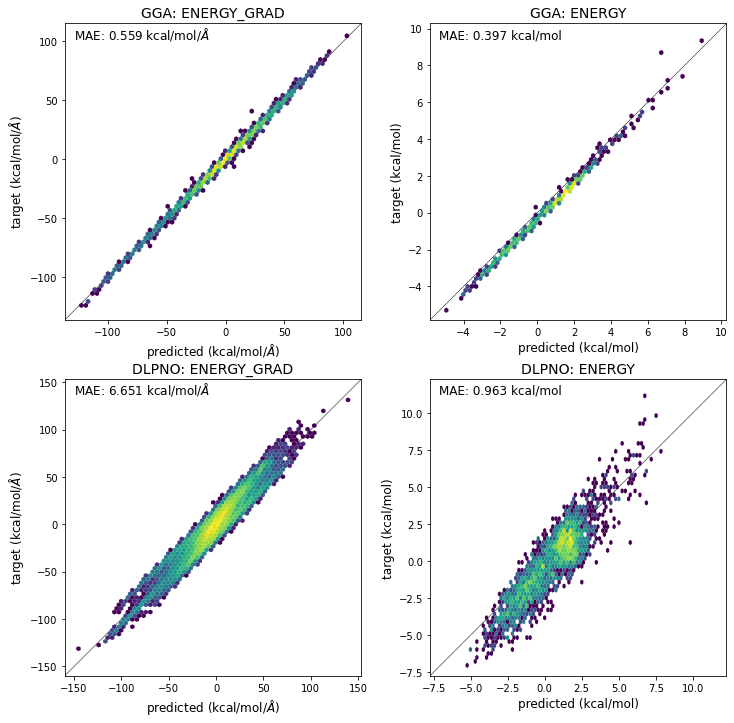

In [14]:
def stack_cat(item):
    try:
        out = torch.stack(item, dim=0)
    except:
        out = torch.cat(item, dim=0)
    return out
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 12))

for ax_row, (method_key, method_loader) in zip(ax_fig, split_loaders.items()):
    
    results, targets, val_loss = evaluate(T.get_best_model(), method_loader['test'], loss_fn, device=DEVICE)
    
    for ax, key in zip(ax_row, units.keys()):
        pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
        targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)

        plot_hexbin(pred, targ, ax, key, scale='linear')

        ax.set_title('%s: %s' % (method[method_key], key.upper()), fontsize=14)

plt.show()

## Transfer learning

Now we just have to freeze its convolution layers and unfreeze the last layers. In our case, the readout layers are those which make the prediction possible.

In [15]:
model = T.get_best_model()
model = freeze_parameters(model)
unfreeze_readout(model)

In [16]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

Retraining the model for a couple more epochs to use the transfer learning strategy:

In [17]:
T_transf = Trainer(
    model_path=OUTDIR_2,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=split_loaders['transf']['train'],
    validation_loader=split_loaders['transf']['val'],
    checkpoint_interval=1,
    hooks=train_hooks
)

In [18]:
T_transf.train(device=DEVICE, n_epochs=15)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | 


 75%|███████▌  | 3/4 [00:00<00:00, 26.59it/s]


35:40 |     1 |     3.000e-04 |    50.0508 |         26.7035 |     0.7280 |          4.1242 | 


 75%|███████▌  | 3/4 [00:00<00:00, 26.69it/s]


35:40 |     2 |     3.000e-04 |    19.3301 |          8.9367 |     0.6058 |          2.2022 | 


 75%|███████▌  | 3/4 [00:00<00:00, 26.70it/s]


35:41 |     3 |     3.000e-04 |     6.9680 |          4.6743 |     0.5005 |          1.7466 | 


 75%|███████▌  | 3/4 [00:00<00:00, 26.66it/s]


35:41 |     4 |     3.000e-04 |     4.7824 |          4.9151 |     0.3839 |          1.7937 | 


 75%|███████▌  | 3/4 [00:00<00:00, 26.43it/s]


35:41 |     5 |     3.000e-04 |     5.0232 |          4.8017 |     0.3069 |          1.6990 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.89it/s]


35:42 |     6 |     3.000e-04 |     4.6316 |          3.9754 |     0.4392 |          1.4344 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.78it/s]


35:42 |     7 |     3.000e-04 |     3.7974 |          3.1270 |     0.6219 |          1.2721 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.72it/s]


35:42 |     8 |     3.000e-04 |     3.0527 |          2.4893 |     0.6354 |          1.1749 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.81it/s]


35:42 |     9 |     3.000e-04 |     2.5460 |          2.1531 |     0.5098 |          1.0961 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.74it/s]


35:43 |    10 |     3.000e-04 |     2.3219 |          2.0586 |     0.3510 |          1.0613 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.86it/s]


35:43 |    11 |     3.000e-04 |     2.2459 |          1.9949 |     0.2207 |          1.0372 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.76it/s]


35:43 |    12 |     3.000e-04 |     2.1541 |          1.8871 |     0.1619 |          1.0128 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.69it/s]


35:43 |    13 |     3.000e-04 |     2.0335 |          1.7734 |     0.1658 |          0.9801 | 


 75%|███████▌  | 3/4 [00:00<00:00, 28.81it/s]


35:44 |    14 |     3.000e-04 |     1.9175 |          1.6742 |     0.1713 |          0.9422 | 


 75%|███████▌  | 3/4 [00:00<00:00, 27.59it/s]


35:44 |    15 |     3.000e-04 |     1.8226 |          1.6124 |     0.1700 |          0.9167 | 


100%|██████████| 28/28 [00:00<00:00, 55.11it/s]


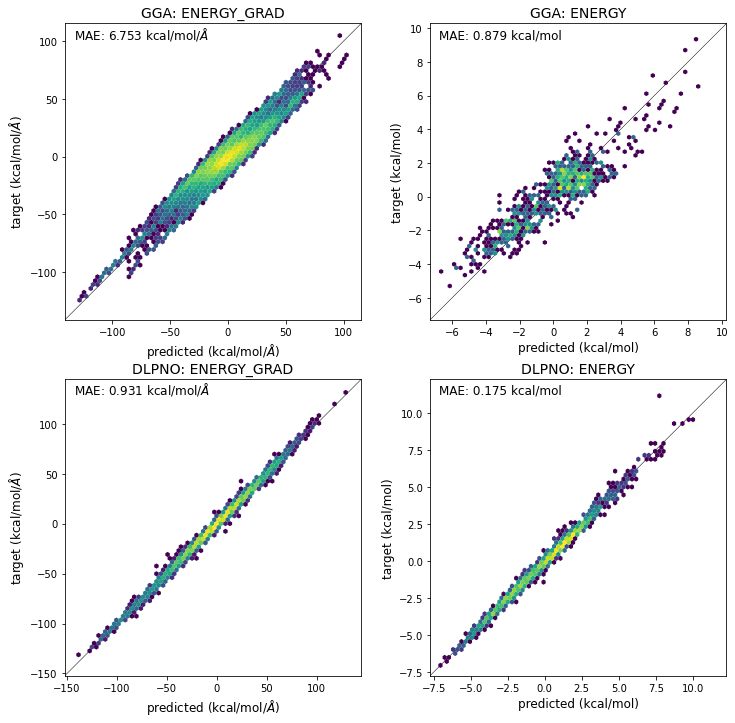

In [19]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 12))

for ax_row, (method_key, method_loader) in zip(ax_fig, split_loaders.items()):
    
    results, targets, val_loss = evaluate(T_transf.get_best_model(), method_loader['test'], loss_fn, device=DEVICE)
    
    for ax, key in zip(ax_row, units.keys()):
        pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
        targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)

        plot_hexbin(pred, targ, ax, key, scale='linear')

        ax.set_title('%s: %s' % (method[method_key], key.upper()), fontsize=14)

plt.show()